In [37]:
import cftime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
from scipy import interpolate
from scipy import io
from scipy import ndimage
import xarray as xr
import cmocean 

import matplotlib as mpl
mpl.rcParams['image.origin'] = 'lower'


%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
mission_df = pd.read_csv('../../data/mission_df.csv')
mission_df[mission_df['mission number']==32]

,Unnamed: 0,time,mission number,Hs [m] (8marray),Tm [s] (8marray),Mean Dir [deg] (8marray),Mean Dir FRF [deg] (8marray),Mean Dir FRF Math conv (8marray),Mean Wavelength [m] (8marray),wind speed [m/s],wind direction [deg],wind direction FRF [deg],wind direction FRF math convention [deg],water level [m],stokes drift [m/s] (8marray),surf zone width [m],breaking iribarren,surf zone edge [m]
39,39,2021-10-13 17:25:29.998680,32,1.08733,7.631857,58.45004,39.450039,230.549961,61.345759,6.483833,4.238652,-14.761348,284.761348,0.781,0.06732,187.884512,0.2701,262.884512


# First, a look at the bathymetry survey

50.0
950.0
-100.0
1100.0


/var/folders/xv/4vxt441n3tz_yllzvqvzmsgw0000gr/T/ipykernel_8255/854348145.py:17: UserWarning: The following kwargs were not used by contour: 'linewidth'
  ax.contour(bathy_x_grid, bathy_y_grid, elevation_basic,


(50.0, 950.0, -100.0, 1100.0)

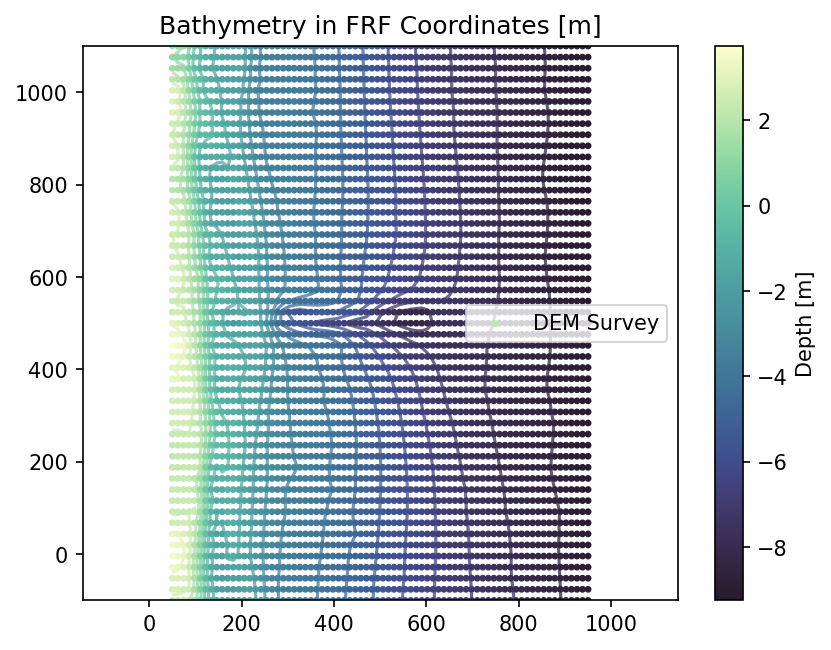

In [7]:
# Load basic processed bathymetry
# Survey DEMs available from https://chldata.erdc.dren.mil/thredds/catalog/frf/geomorphology/DEMs/surveyDEM/data/catalog.html
# Some of this code is from EJ Rainville's earlier work on this model
survey_20211021 = nc.Dataset('../../data/FRF_geomorphology_DEMs_surveyDEM_20211021.nc')

xFRF = survey_20211021['xFRF'][:]
yFRF = survey_20211021['yFRF'][:]
bathy_x_grid, bathy_y_grid = np.meshgrid(xFRF, yFRF)
elevation_basic = survey_20211021['elevation'][0,:,:]
print(np.min(xFRF))
print(np.max(xFRF))
print(np.min(yFRF))
print(np.max(yFRF))

fig, ax = plt.subplots(dpi=150)
im = ax.scatter(bathy_x_grid, bathy_y_grid, c=elevation_basic, 
           s=5, vmin=elevation_basic.min(), vmax=elevation_basic.max(),
           cmap=cmocean.cm.deep_r, label='DEM Survey')
plt.colorbar(im, ax=ax, label='Depth [m]')
ax.contour(bathy_x_grid, bathy_y_grid, elevation_basic, 
           levels=np.linspace(elevation_basic.min(), elevation_basic.max(), 21), 
           cmap=cmocean.cm.deep_r, zorder=-1, alpha=0.75, linewidth=10)
stride = 15

ax.legend()
ax.set_title('Bathymetry in FRF Coordinates [m]')
plt.xlim([0, np.max(xFRF)])
plt.ylim([0, np.max(yFRF)])
plt.axis('equal')

# Next we'll define the computational grid for the simulation

901
1001
(2002, 901)
Values to put in SWAN input file 900 1000


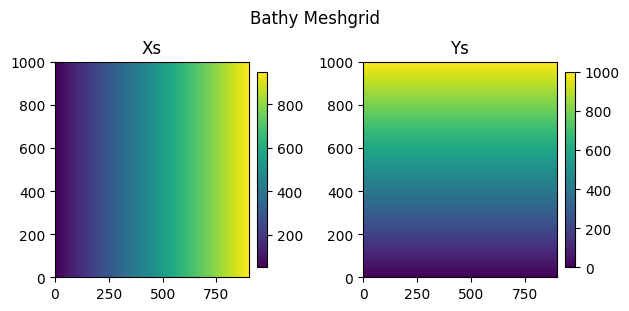

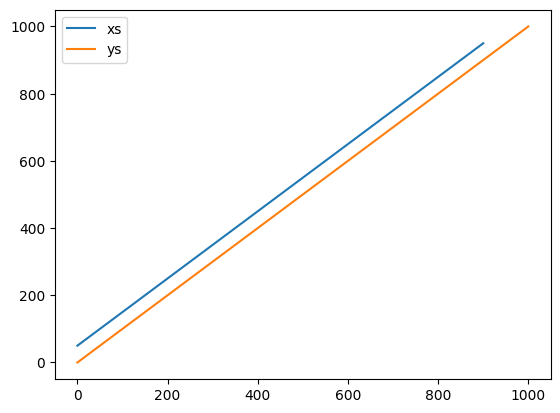

In [8]:
# Define grid cell edge size
x_cgrid_size = 1 # units are meters
y_cgrid_size = 1 # units are meters

# Define grid edges
x_cgrid_min = 50
x_cgrid_max = 950
y_cgrid_min = 0
y_cgrid_max = 1000

# Define number of points based on grid size
num_x_points = int((x_cgrid_max - x_cgrid_min) / x_cgrid_size)+1
print(num_x_points)
num_y_points = int((y_cgrid_max - y_cgrid_min) / y_cgrid_size)+1
print(num_y_points)

# Create mesh grid
x_cgrid, y_cgrid = np.meshgrid(np.linspace(x_cgrid_min, x_cgrid_max, num_x_points),
                               np.linspace(y_cgrid_min, y_cgrid_max, num_y_points))

# Stack the x grid and y grid to be read into swan
swan_cgrid = np.concatenate((x_cgrid, y_cgrid), axis=0)
print(swan_cgrid.shape)

with open('./swan_cgrid.xy', 'w') as file:
    for x in x_cgrid.flatten():
        file.write(f"{x:18.12f}\n")
    for y in y_cgrid.flatten():
        file.write(f"{y:18.12f}\n")

# Save the grid to load in for analysis
io.savemat('./swan_cgrid.mat', {'x_cgrid':x_cgrid, 'y_cgrid':y_cgrid})

print(f'Values to put in SWAN input file {num_x_points-1} {num_y_points-1}')

fig, axs = plt.subplots(1, 2)
xs = axs[0].imshow(x_cgrid, vmin=50, vmax=950, origin='lower')
axs[0].set_title('Xs')
plt.colorbar(xs, ax=axs[0], fraction=0.046, pad=0.04)
ys = axs[1].imshow(y_cgrid, origin='lower')
axs[1].set_title('Ys')
plt.colorbar(ys, ax=axs[1],fraction=0.046, pad=0.04)
fig.suptitle('Bathy Meshgrid', y=0.8)
plt.tight_layout()

plt.figure()
plt.plot(x_cgrid[0, :], label='xs')
plt.plot(y_cgrid[:, 0], label='ys')
plt.legend()

(0.0, 1000.0)

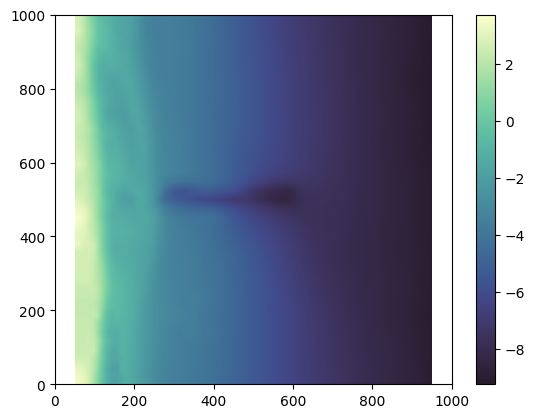

In [9]:
# Grid the elevation on these coordinates
elevation_regridded = interpolate.interpn((xFRF, yFRF), elevation_basic.T, (x_cgrid, y_cgrid), method='linear', fill_value=0)
fig, ax = plt.subplots()
im = ax.pcolormesh(x_cgrid, y_cgrid, elevation_regridded[1:, 1:], shading='flat', cmap=cmocean.cm.deep_r)
fig.colorbar(im)
plt.xlim([0, 1000])
plt.ylim([0, 1000])


Text(0.5, 1.0, 'Interpolated Boundary from top')

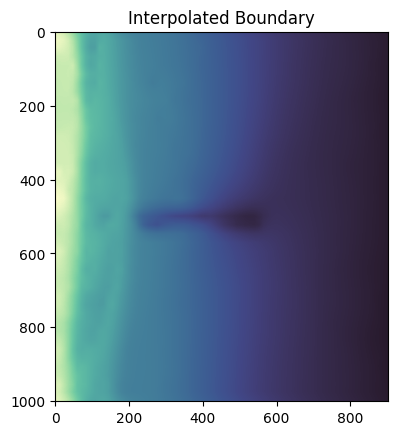

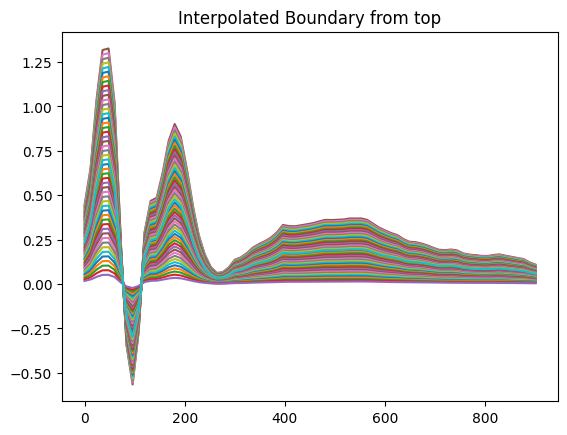

In [10]:
# Create a smooth N-S boundary

elevation_regridded_boundary_interp = elevation_regridded.copy()

n_interp = 51
interp_indices = np.arange(-n_interp//2+1, n_interp//2+1, 1)

# Linear interpolation along cross-shore transects
start_depths = elevation_regridded[interp_indices[-1]]
end_depths =   elevation_regridded[interp_indices[0]]
slope = (end_depths - start_depths) / n_interp

for i, along_shore in enumerate(interp_indices):
    elevation_regridded_boundary_interp[along_shore, :] = end_depths - (i * slope)

plt.imshow(elevation_regridded_boundary_interp,  cmap=cmocean.cm.deep_r)
plt.title('Interpolated Boundary')

plt.figure()
plt.plot(start_depths[:, np.newaxis] - elevation_regridded_boundary_interp[:25, :].T)
plt.plot(start_depths[:, np.newaxis] - elevation_regridded_boundary_interp[-25:, :].T);
plt.title('Interpolated Boundary from top')


# Create the requisite files

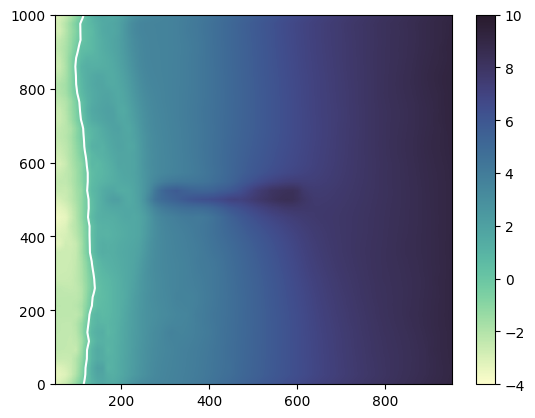

In [ ]:
water_depth_nadv88 = -elevation_regridded_boundary_interp # From bathymetry elevation (land is positive) to depths  

assert(~np.any(np.isnan(water_depth_nadv88)))
# elevation_clipped[elevation_clipped < 0.1] = 0

plt.pcolormesh(x_cgrid, y_cgrid, water_depth_nadv88, vmin=-4, vmax=10, cmap=cmocean.cm.deep)
plt.colorbar()
plt.contour(x_cgrid, y_cgrid, water_depth_nadv88, levels=[0], colors='white')


io.savemat('./FRF_geomorphology_DEMs_surveyDEM_20211021_grid.mat', 
           {'x':x_cgrid.T,
            'y':y_cgrid.T,
            'depth':water_depth_nadv88.T,
            'mask_rho':water_depth_nadv88.T<0.05, 
            'fname':'FRF_geomorphology_DEMs_surveyDEM_20211021_grid.nc'});
# Then run `create_roms_xygrid` with the following snipped to unpack the variables where indicated 
#   https://code.usgs.gov/coawstmodel/COAWST/-/blob/master/Tools/mfiles/mtools/create_roms_xygrid.m
# You will need the whole Tools folder in your path
'''matlab
load('FRF_geomorphology_DEMs_surveyDEM_20211021_grid.mat');
fname='FRF_geomorphology_DEMs_surveyDEM_20211021_grid.nc';
''';

<xarray.Dataset> Size: 202MB
Dimensions:    (one: 1, bath: 1, eta_rho: 1001, xi_rho: 901, eta_psi: 1000,
                xi_psi: 900, eta_u: 1001, xi_u: 900, eta_v: 1000, xi_v: 901)
Dimensions without coordinates: one, bath, eta_rho, xi_rho, eta_psi, xi_psi,
                                eta_u, xi_u, eta_v, xi_v
Data variables: (12/34)
    xl         (one) float64 8B 900.0
    el         (one) float64 8B 1e+03
    JPRJ       |S2 2B b'ME'
    spherical  (one) |S1 1B b'F'
    depthmin   (one) int16 2B -3
    depthmax   (one) int16 2B 9
    ...         ...
    lon_v      (eta_v, xi_v) float64 7MB 0.0004497 0.0004587 ... 0.008544
    mask_rho   (eta_rho, xi_rho) float64 7MB 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0
    mask_u     (eta_u, xi_u) float64 7MB 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0
    mask_v     (eta_v, xi_v) float64 7MB 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0
    mask_psi   (eta_psi, xi_psi) float64 7MB 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0
    angle      (eta_rho, xi_rho) float64 7MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    type:     ROMS GRID file
    gridid:   theGridTitle
    history:  Created by create_roms_netcdf_grid_file, on 09-Sep-2024 14:57:00
    title:    ROMS Application

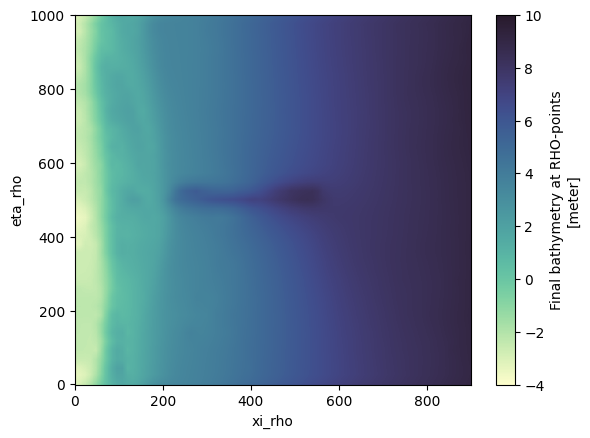

In [30]:
roms_grid = xr.load_dataset('FRF_geomorphology_DEMs_surveyDEM_20211021/FRF_geomorphology_DEMs_surveyDEM_20211021_grid.nc')
roms_grid.h.plot(vmin=-4, vmax=10, cmap=cmocean.cm.deep)
roms_grid

# Check the Water Level

navd88_water_level=0.781


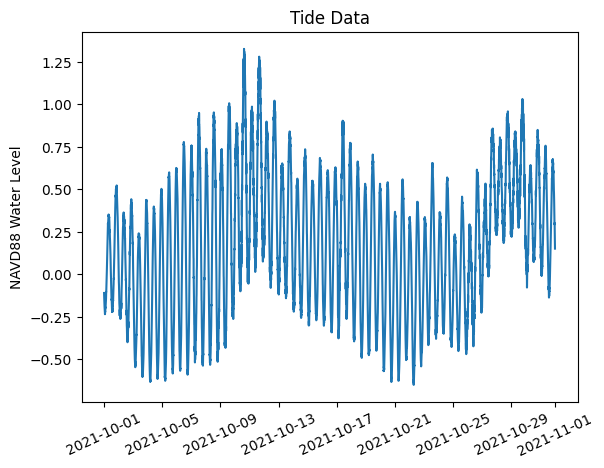

In [ ]:
tides = xr.load_dataset('../../data/FRF-ocean_waterlevel_eopNoaaTide_202110.nc')
water_level = tides.waterLevel # relative NAVD88 just like bathymetry
plt.plot(water_level.time, water_level)
plt.xticks(rotation=25)
plt.ylabel('NAVD88 Water Level')
plt.title('Tide Data')
mission_id = 32
mission = xr.load_dataset(f'../../../data/swift/doi_10_5061_dryad_hx3ffbgk0__v20230321/mission_{mission_id}.nc')
navd88_water_level = water_level.sel(time=mission.time.mean(), method='nearest').item()
print(f'{navd88_water_level=}')

# Check Rip Current file

<xarray.Dataset> Size: 9MB
Dimensions:    (one: 1, bath: 0, eta_rho: 263, xi_rho: 152, eta_psi: 262,
                xi_psi: 151, eta_u: 263, xi_u: 151, eta_v: 262, xi_v: 152)
Dimensions without coordinates: one, bath, eta_rho, xi_rho, eta_psi, xi_psi,
                                eta_u, xi_u, eta_v, xi_v
Data variables: (12/34)
    xl         (one) float64 8B 302.0
    el         (one) float64 8B 524.0
    JPRJ       |S2 2B b'ME'
    depthmin   (one) int16 2B 0
    depthmax   (one) int16 2B 10
    spherical  (one) |S1 1B b'F'
    ...         ...
    lon_v      (eta_v, xi_v) float64 319kB 0.0 1.799e-05 ... 0.002698 0.002716
    mask_rho   (eta_rho, xi_rho) float64 320kB 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
    mask_u     (eta_u, xi_u) float64 318kB 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    mask_v     (eta_v, xi_v) float64 319kB 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    mask_psi   (eta_psi, xi_psi) float64 316kB 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
    angle      (eta_rho, xi_rho) float64 320kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    type:     ROMS GRID file
    gridid:   theGridTitle
    history:  Created by "mat2roms_jcw" on 01-Apr-2011 20:45:28
    title:    ROMS Application

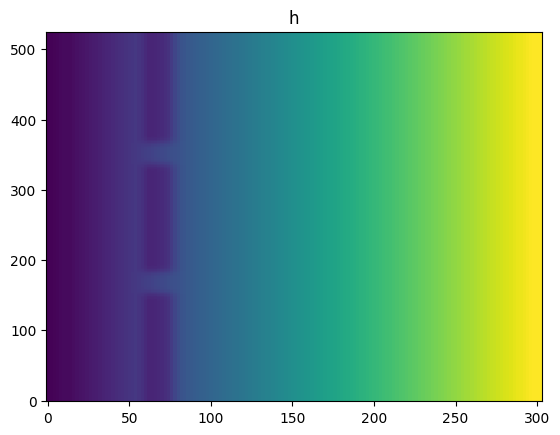

In [38]:
orc = xr.load_dataset('ocean_rip_current_grd.nc')
plt.pcolormesh(orc.x_rho, orc.y_rho, orc.h)
plt.title('h')
orc

Text(0.5, 1.0, 'y_rho')

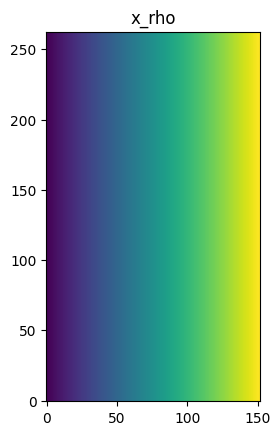

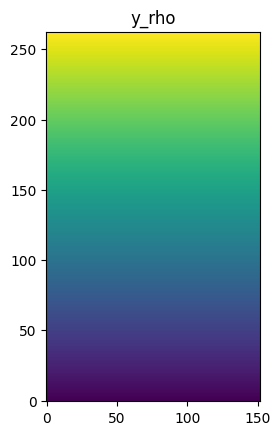

In [39]:
# Simple sanity check
plt.imshow(orc.x_rho)
plt.title('x_rho')
plt.figure()
plt.imshow(orc.y_rho)
plt.title('y_rho')

plt.imshow(roms_grid.x_rho)
plt.title('x_rho')
plt.figure()
plt.imshow(roms_grid.y_rho)
plt.title('y_rho')
